#### Source: https://learnopencv.com/t-sne-for-feature-visualization/

In [ ]:
import argparse
from tqdm import tqdm
import cv2
import torch
import random
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.models import resnet18, resnet50, resnet101

# from resnet import ResNet101

In [ ]:
import os
import shutil
import glob as gb
import torch
import torch.nn as nn
#import torch.optim as optim
#from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
#from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare Data

In [ ]:
# Fetch dataset
!unzip /content/drive/MyDrive/machine_learning/datasets/2D_3D_portraits.zip > /dev/null
# !unzip /content/drive/MyDrive/machine_learning/datasets/animals10.zip -d data > /dev/null

In [ ]:
# Optionally create a separate folder with the images to be tested
DATASET_PATH = "2D_3D_portraits/*" #"disney_test_3D_portraits"
DST_PATH = "test"

for i in ['human', 'humanoid', 'animal', 'machine', 'all']:
  for j in ['male', 'female']:
    dir = f'{DST_PATH}/{i}/{j}'
    # delete folder contents if already exist
    if os.path.exists(dir):
      shutil.rmtree(dir)
    os.makedirs(dir)

for d in ["test"]:
  for char_style in ['human', 'humanoid', 'animal', 'machine']:
    females = [os.path.abspath(f) for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/female/*.jpg"))]
    males = [os.path.abspath(f) for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/male/*.jpg"))]
    # females = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{char_style}/female/*.jpg"))]
    # males = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{char_style}/male/*.jpg"))]

    # Randomly shuffle all images and select equal number of faces
    import random
    random.seed(0)
    random.shuffle(females)
    random.shuffle(males)

    if len(females) < len(males):
      males_subset = random.sample(males, len(females))
      males = males_subset
    else:
      females_subset = random.sample(females, len(males))
      females = females_subset

    # Copy files into destination folders
    for gender, gender_list in {'female':females, 'male':males}.items():
      for full_fname in gender_list:
        fname = full_fname.split("/")[-1]
        shutil.copyfile(full_fname, f"{DST_PATH}/{char_style}/{gender}/{fname}")
        shutil.copyfile(full_fname, f"{DST_PATH}/all/{gender}/{fname}") # all character styles together

In [ ]:
# Set path
data_dir = 'test'

# Gender distribution per character style
N = 0  # total files
gender_dist = {}
for dirpath, dirnames, filenames in os.walk(data_dir): 
    N_c = len(filenames)
    N += N_c
    #print("Files in ", dirpath, dirnames, N_c)

    if not dirnames: # list is empty so have full string and num files
      char_style = dirpath.split("/")[-2]
      label = dirpath.split("/")[-1]
      gender_dist[f"{char_style}_{label}"]= N_c

print("Total Files ", N)
print(gender_dist)

Total Files  5580
{'human_female': 699, 'human_male': 699, 'humanoid_female': 242, 'humanoid_male': 242, 'animal_female': 449, 'animal_male': 449, 'all_female': 1395, 'all_male': 1395, 'machine_female': 5, 'machine_male': 5}


## Prepare the Model

In [ ]:
# Fetch model
!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet101/003_new.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet101/004.zip > /dev/null

replace output/accuracies_gender.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Load model
model_name = 'model_best.pt' # 'RES18_FeatureExtractor_FineTuned_Disney_Checkpoint11_model.pth'
path_to_model = f'/content/output/{model_name}'
model = models.resnet50(pretrained=True) # resnet18 or resnet50
num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, len(class_names))
class_names = ["female", "male"]
model.fc = nn.Linear(num_features, len(class_names))
model = torch.load(path_to_model, map_location=device) # map to cpu
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Prepare Classes

In [ ]:
from os import path, listdir
import torch
from torchvision import transforms
import random

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


colors_per_class = {
    'male' : [254, 202, 87],
    'female' : [255, 159, 243],
}


class CartoonDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, num_images=1000):

        if not path.exists(data_path):
            raise Exception(data_path + ' does not exist!')

        self.data = []

        folders = listdir(data_path)
        for folder in folders:
            label = folder

            full_path = path.join(data_path, folder)
            images = listdir(full_path)

            current_data = [(path.join(full_path, image), label) for image in images]
            self.data += current_data

        num_images = min(num_images, len(self.data))
        self.data = random.sample(self.data, num_images) # only use num_images images

        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        image_path, label = self.data[index]

        image = Image.open(image_path)

        try:
            image = self.transform(image) # some images in the dataset cannot be processed - we'll skip them
        except Exception:
            return None

        dict_data = {
            'image' : image,
            'label' : label,
            'image_path' : image_path
        }
        return dict_data


# Skips empty samples in a batch
def collate_skip_empty(batch):
    batch = [sample for sample in batch if sample] # check that sample is not None
    return torch.utils.data.dataloader.default_collate(batch)


In [ ]:
## ResNet101
import torch
from torchvision import models
from torch.hub import load_state_dict_from_url

# Define the architecture by modifying resnet.
# Original code is here http://tiny.cc/8zpmmz 
class ResNet101(models.ResNet):
    def __init__(self, num_classes=2, pretrained=True, **kwargs): # classes are female and male
        # Start with the standard resnet101
        super().__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 23, 3],
            num_classes=num_classes,
            **kwargs
        )
        if pretrained:
            state_dict = model.state_dict()
            self.load_state_dict(state_dict)

    # Reimplementing forward pass.
    # Replacing the forward inference defined here 
    # http://tiny.cc/23pmmz
    def _forward_impl(self, x):
        # Standard forward for resnet
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Notice there is no forward pass through the original classifier.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

In [ ]:
## ResNet50
import torch
from torchvision import models
from torch.hub import load_state_dict_from_url

# Define the architecture by modifying resnet.
# Original code is here http://tiny.cc/8zpmmz 
class ResNet50(models.ResNet):
    def __init__(self, num_classes=2, pretrained=True, **kwargs): # classes are female and male
        # Start with the standard resnet101
        super().__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 6, 3],
            num_classes=num_classes,
            **kwargs
        )
        if pretrained:
            state_dict = model.state_dict()
            self.load_state_dict(state_dict)

    # Reimplementing forward pass.
    # Replacing the forward inference defined here 
    # http://tiny.cc/23pmmz
    def _forward_impl(self, x):
        # Standard forward for resnet
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Notice there is no forward pass through the original classifier.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

## t-SNE

In [ ]:
def fix_random_seeds():
    seed = 10
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)


def get_features(dataset, batch, num_images):
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    ### initialize our implementation of ResNet ###
    model = ResNet101(pretrained=True)
    #model = ResNet50(pretrained=True)
    model.eval()
    model.to(device)

    # read the dataset and initialize the data loader
    #dataset = AnimalsDataset(dataset, num_images)
    dataset = CartoonDataset(dataset, num_images)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, collate_fn=collate_skip_empty, shuffle=True)

    # we'll store the features as NumPy array of size num_images x feature_size
    features = None

    # we'll also store the image labels and paths to visualize them later
    labels = []
    image_paths = []

    for batch in tqdm(dataloader, desc='Running the model inference'):
        images = batch['image'].to(device)
        labels += batch['label']
        image_paths += batch['image_path']

        with torch.no_grad():
            output = model.forward(images)

        current_features = output.cpu().numpy()
        if features is not None:
            features = np.concatenate((features, current_features))
        else:
            features = current_features

    return features, labels, image_paths


# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image


def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape

    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color, thickness=5)

    return image


def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y


def visualize_tsne_images(tx, ty, images, labels, plot_size=1000, max_image_size=100):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8) #255

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, label, x, y in tqdm(
            zip(images, labels, tx, ty),
            desc='Building the T-SNE plot',
            total=len(images)
    ):
        image = cv2.imread(image_path)

        # scale the image to put it to the plot
        image = scale_image(image, max_image_size)

        # draw a rectangle with a color corresponding to the image class
        image = draw_rectangle_by_class(image, label)

        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    plt.figure(figsize=(20, 20))
    plt.imshow(tsne_plot[:, :, ::-1])
    # hide ticks
    plt.xticks([])
    plt.yticks([])
    plt.savefig("tsne_images_human.pdf")
    plt.show()


def visualize_tsne_points(tx, ty, labels):
    # initialize matplotlib plot
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111) #111

    # for every class, we'll add a scatter plot separately
    for label in colors_per_class:
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(labels) if l == label]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        # convert the class color to matplotlib format:
        # BGR -> RGB, divide by 255, convert to np.array
        color = np.array([colors_per_class[label][::-1]], dtype=np.float) / 255

        # add a scatter plot with the correponding color and label
        ax.scatter(current_tx, current_ty, c=color, label=label)

    # build a legend using the labels we set previously
    # ax.legend(loc='best')

    # hide axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # finally, show the plot
    plt.savefig("tsne_points_2d.pdf")
    plt.show()


def visualize_tsne(tsne, images, labels, plot_size=2500, max_image_size=100):
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    # scale and move the coordinates so they fit [0; 1] range
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    # visualize the plot: samples as colored points
    visualize_tsne_points(tx, ty, labels)

    # visualize the plot: samples as images
    visualize_tsne_images(tx, ty, images, labels, plot_size=plot_size, max_image_size=max_image_size)


In [ ]:
fix_random_seeds()
features, labels, image_paths = get_features(
        #dataset='data/raw-img',
        dataset='test2d/all',
        batch=64,
        num_images=20000
    )
tsne = TSNE(n_components=2).fit_transform(features)

Running the model inference: 100%|██████████| 19/19 [06:04<00:00, 19.20s/it]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


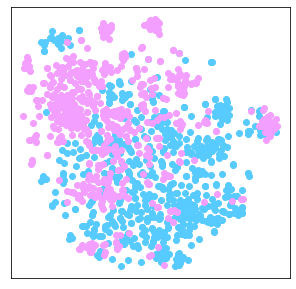

Building the T-SNE plot: 100%|██████████| 1192/1192 [00:01<00:00, 951.06it/s]


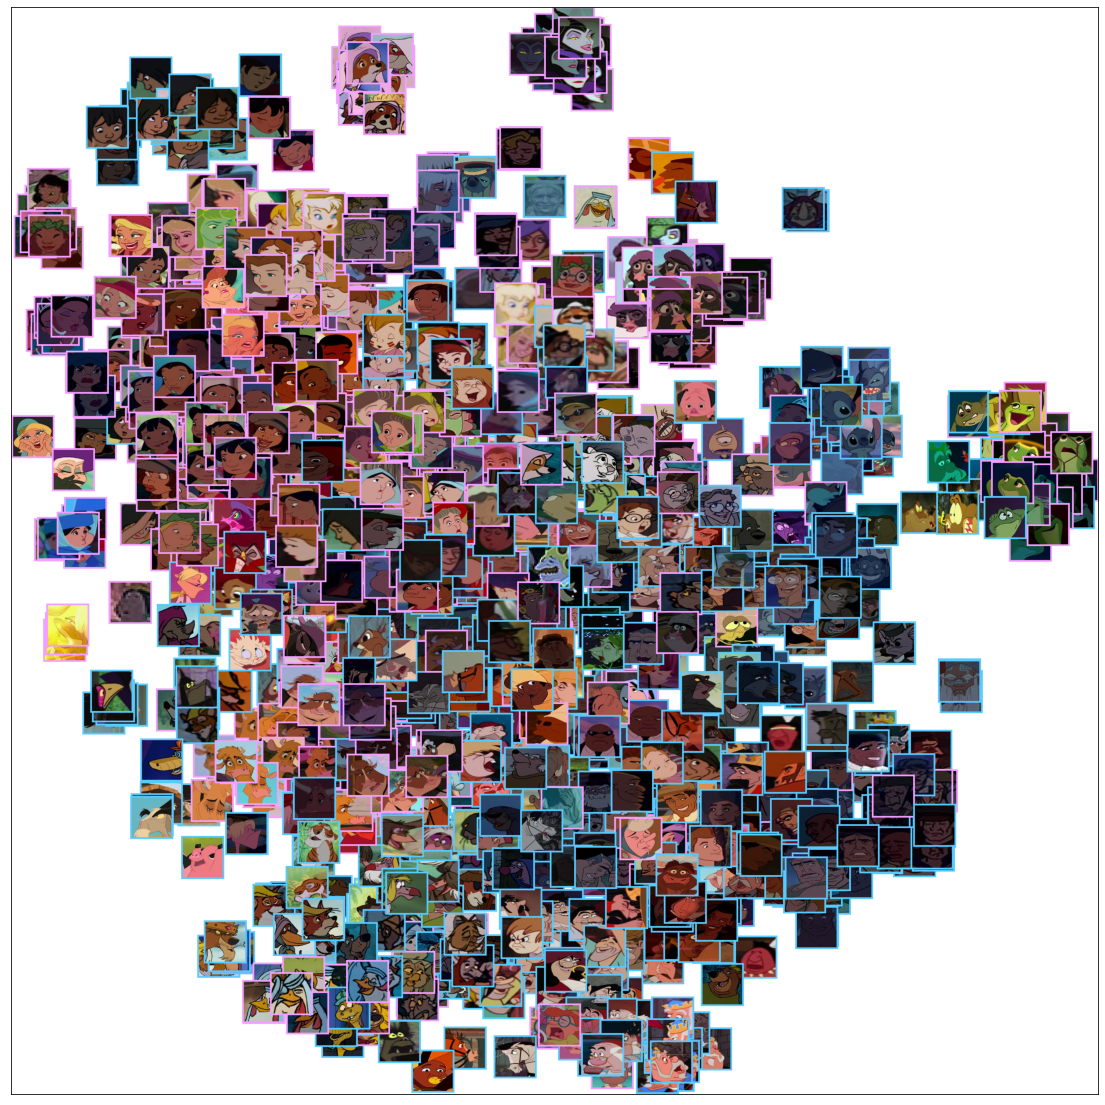

In [ ]:
visualize_tsne(tsne, image_paths, labels)